In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, GRU, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.stats import norm
from scipy import stats

/home/gorka/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-06-06 07:16:19.839166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 07:16:19.839243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 07:16:19.924491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

# Exploratory data analysis

In [2]:
# Load all files
cities = pd.read_csv("city_attributes.csv")
humidity = pd.read_csv("humidity.csv")
temperature = pd.read_csv("temperature.csv")
pressure = pd.read_csv("pressure.csv")
weather_description = pd.read_csv("weather_description.csv")
wind_direction = pd.read_csv("wind_direction.csv")
wind_speed = pd.read_csv("wind_speed.csv")

In [3]:
# Modify the format of the data for later merging
humidity_melted = humidity.melt(id_vars=['datetime'], var_name='City', value_name='Humidity')
pressure_melted = pressure.melt(id_vars=['datetime'], var_name='City', value_name='Pressure')
temperature_melted = temperature.melt(id_vars=['datetime'], var_name='City', value_name='Temperature')
weather_description_melted = weather_description.melt(id_vars=['datetime'], var_name='City', value_name='Weather_Description')
wind_direction_melted = wind_direction.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Direction')
wind_speed_melted = wind_speed.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Speed')

In [4]:
# Combine all dataframes
combined_df = humidity_melted.merge(pressure_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(temperature_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(weather_description_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(wind_direction_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(wind_speed_melted, on=['datetime', 'City'])

In [5]:
# Change temperature units from Kelvin to Celsius
combined_df["temp_C"] = combined_df["Temperature"] - 273.15

In [6]:
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], format='%Y-%m-%d %H:%M:%S')
combined_df.set_index("datetime")

City  Humidity  Pressure  Temperature  \
datetime                                                          
2012-10-01 12:00:00  Vancouver       NaN       NaN          NaN   
2012-10-01 13:00:00  Vancouver      76.0       NaN   284.630000   
2012-10-01 14:00:00  Vancouver      76.0       NaN   284.629041   
2012-10-01 15:00:00  Vancouver      76.0       NaN   284.626998   
2012-10-01 16:00:00  Vancouver      77.0       NaN   284.624955   
...                        ...       ...       ...          ...   
2017-11-29 20:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 21:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 22:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 23:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-30 00:00:00  Jerusalem       NaN       NaN          NaN   

                    Weather_Description  Wind_Direction  Wind_Speed     temp_C  
datetime                                                                        
2012-10-01 12:00:00                 NaN             NaN         NaN        NaN  
2012-10-01 13:00:00                mist             0.0         0.0  11.480000  
2012-10-01 14:00:00       broken clouds             6.0         0.0  11.479041  
2012-10-01 15:00:00       broken clouds            20.0         0.0  11.476998  
2012-10-01 16:00:00       broken clouds            34.0         0.0  11.474955  
...                                 ...             ...         ...        ...  
2017-11-29 20:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 21:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 22:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 23:00:00                 NaN             NaN         NaN        NaN  
2017-11-30 00:00:00                 NaN             NaN         NaN        NaN  

[1629108 rows x 8 columns]

In [7]:
combined_df.head()

datetime       City  Humidity  Pressure  Temperature  \
0 2012-10-01 12:00:00  Vancouver       NaN       NaN          NaN   
1 2012-10-01 13:00:00  Vancouver      76.0       NaN   284.630000   
2 2012-10-01 14:00:00  Vancouver      76.0       NaN   284.629041   
3 2012-10-01 15:00:00  Vancouver      76.0       NaN   284.626998   
4 2012-10-01 16:00:00  Vancouver      77.0       NaN   284.624955   

  Weather_Description  Wind_Direction  Wind_Speed     temp_C  
0                 NaN             NaN         NaN        NaN  
1                mist             0.0         0.0  11.480000  
2       broken clouds             6.0         0.0  11.479041  
3       broken clouds            20.0         0.0  11.476998  
4       broken clouds            34.0         0.0  11.474955

In [8]:
print("Missing data by column and city:")
null_count = combined_df.isnull().groupby(combined_df['City']).sum()
null_count['total'] = null_count.sum(axis=1)
null_count

Missing data by column and city:


datetime  City  Humidity  Pressure  Temperature  \
City                                                                 
Albuquerque               0     0       710       456            1   
Atlanta                   0     0       422        49            6   
Beersheba                 0     0       859       806          798   
Boston                    0     0       449         7            3   
Charlotte                 0     0       589         3            3   
Chicago                   0     0      1109       725            3   
Dallas                    0     0       319        60            4   
Denver                    0     0      1808       543            1   
Detroit                   0     0       862         5            1   
Eilat                     0     0       970       792          792   
Haifa                     0     0       818       798          798   
Houston                   0     0       121         9            3   
Indianapolis              0     0       695       289            7   
Jacksonville              0     0       209        15            1   
Jerusalem                 0     0       906       799          793   
Kansas City               0     0       512       121            1   
Las Vegas                 0     0       842        88            1   
Los Angeles               0     0       152       252            3   
Miami                     0     0      1087       794          805   
Minneapolis               0     0       510        17           13   
Montreal                  0     0      1696       994            3   
Nahariyya                 0     0       817       795          797   
Nashville                 0     0       567       147            2   
New York                  0     0      1624      1041          793   
Philadelphia              0     0       624         4            3   
Phoenix                   0     0      1308       594            3   
Pittsburgh                0     0       522        46            3   
Portland                  0     0       449         4            1   
Saint Louis               0     0      1289        68            1   
San Antonio               0     0       564        17            1   
San Diego                 0     0       344       175            1   
San Francisco             0     0       942       815          793   
Seattle                   0     0       289        13            3   
Tel Aviv District         0     0      1113       930          793   
Toronto                   0     0       728       175            1   
Vancouver                 0     0      1826      4234          795   

                   Weather_Description  Wind_Direction  Wind_Speed  temp_C  \
City                                                                         
Albuquerque                          1               1           4       1   
Atlanta                              1               1           1       6   
Beersheba                          793             793         793     798   
Boston                               1               1           1       3   
Charlotte                            1               1           2       3   
Chicago                              1               1           1       3   
Dallas                               1               1           2       4   
Denver                               1               1           2       1   
Detroit                              1               1           1       1   
Eilat                              792             797         792     792   
Haifa                              793             793         795     798   
Houston                              1               2           3       3   
Indianapolis                         1               1           1       7   
Jacksonville                         1               5           1       1   
Jerusalem                          793             793         794     793   
Kansas City                     

From now on we will work just with data from Dallas (for not reason in particular).

In [9]:
dallas = combined_df[combined_df["City"]=="Dallas"]

In [10]:
# Upsampling by backwards filling to work around missing values
dallas=dallas.bfill()
dallas.isnull().sum()

datetime               0
City                   0
Humidity               0
Pressure               0
Temperature            0
Weather_Description    0
Wind_Direction         0
Wind_Speed             0
temp_C                 0
dtype: int64

In [11]:
print("Information about the data:")
dallas.info()

Information about the data:
<class 'pandas.core.frame.DataFrame'>
Index: 45253 entries, 497783 to 543035
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             45253 non-null  datetime64[ns]
 1   City                 45253 non-null  object        
 2   Humidity             45253 non-null  float64       
 3   Pressure             45253 non-null  float64       
 4   Temperature          45253 non-null  float64       
 5   Weather_Description  45253 non-null  object        
 6   Wind_Direction       45253 non-null  float64       
 7   Wind_Speed           45253 non-null  float64       
 8   temp_C               45253 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 3.5+ MB


In [12]:
print("Summary statistics of the data:")
dallas.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Summary statistics of the data:


datetime     Humidity     Pressure  Temperature Wind_Direction  \
count  45253.00000  45253.00000  45253.00000  45253.00000    45253.00000   
mean           .5f     64.26756   1018.89861    292.37568      166.07655   
min            .5f      9.00000    979.00000    261.61033        0.00000   
25%            .5f     50.00000   1013.00000    285.72000      110.00000   
50%            .5f     65.00000   1017.00000    293.56300      167.00000   
75%            .5f     79.00000   1025.00000    299.55000      201.00000   
max            .5f    100.00000   1071.00000    314.40000      360.00000   
std            nan     19.60680      9.02920      9.46443       91.41640   

        Wind_Speed       temp_C  
count  45253.00000  45253.00000  
mean       3.63191     19.22568  
min        0.00000    -11.53967  
25%        2.00000     12.57000  
50%        3.00000     20.41300  
75%        5.00000     26.40000  
max       50.00000     41.25000  
std        2.20791      9.46443

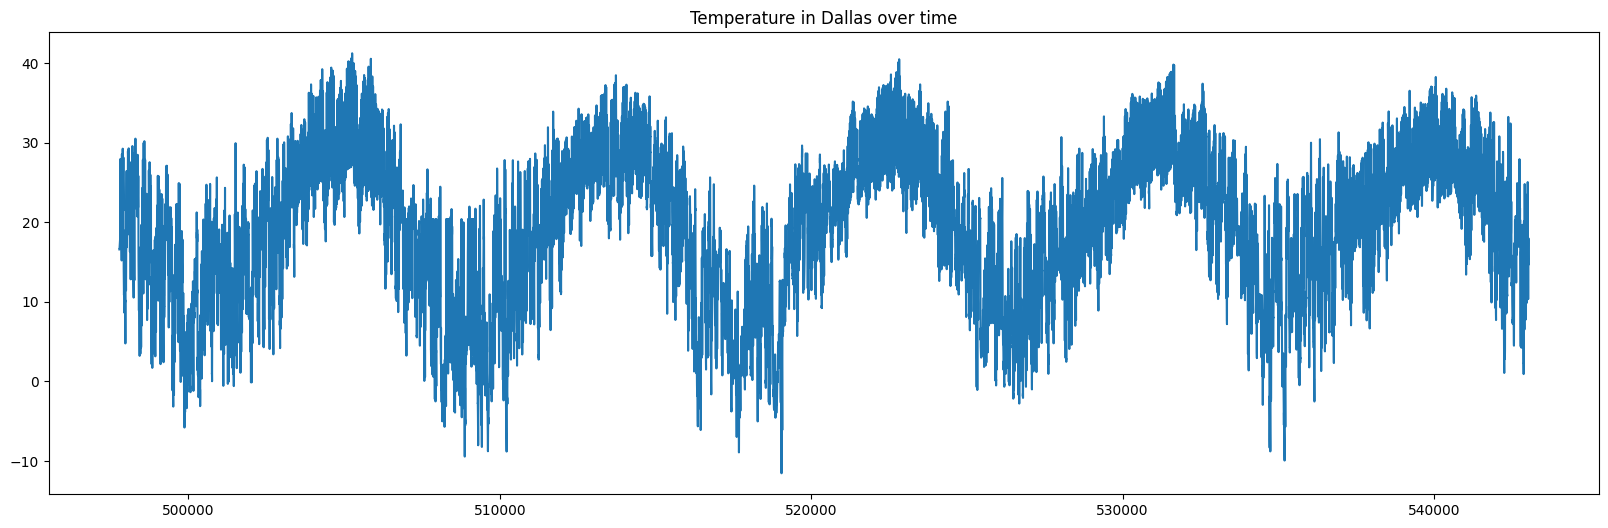

In [13]:
plt.figure(figsize=(20, 6))
dallas['temp_C'].plot() 
plt.title('Temperature in Dallas over time')
plt.show()

In [14]:
# Same plot as above but using plotly library
fig = go.Figure([go.Scatter(x=dallas['datetime'], y=dallas['temp_C'])])
fig.update_layout(
    title={
        'text': "Temperature in Dallas over time",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Temp (°C)"
)
fig.show()

/usr/lib/python3/dist-packages/_plotly_utils/basevalidators.py:107: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [15]:
# Comparing all the different years
fig = go.Figure()
for year in [2012,2013,2014,2015,2016,2017]:
     fig.add_trace(go.Scatter(x=np.arange(1, 366*24), y=dallas[(dallas["datetime"].dt.year==year)]['temp_C'],mode='lines', name=str(year)))
fig.update_layout(
    title={
        'text': "Comparisson of temperature in Dallas",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Temp (°C)"
)
fig.show()

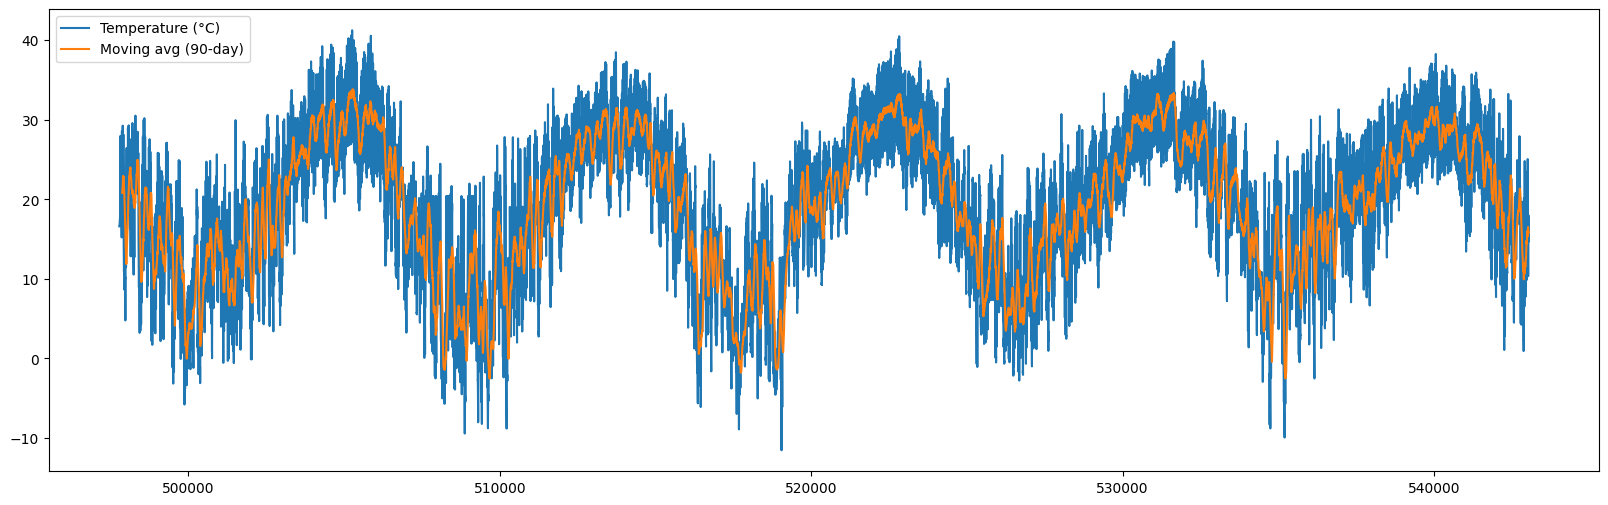

In [16]:
plt.figure(figsize=(20, 6))
dallas['temp_C'].plot()
dallas["temp_C"].rolling(90).mean().plot()
plt.legend(['Temperature (°C)','Moving avg (90-day)'])
plt.show()

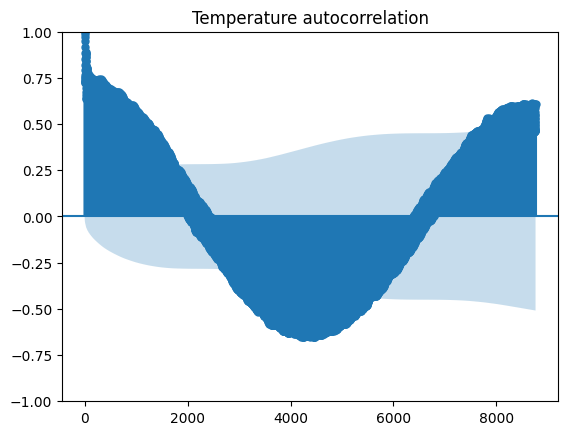

In [17]:
# Autocorrelation of temperature
plot_acf(dallas["temp_C"],lags=24*365,title="Temperature autocorrelation")
plt.show()

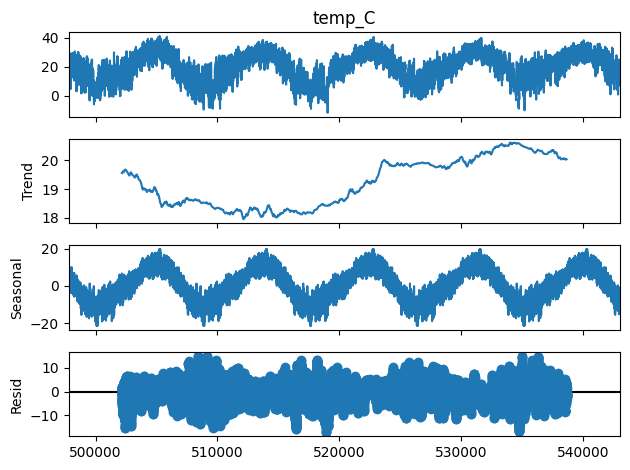

In [18]:
sm.tsa.seasonal_decompose(dallas["temp_C"], period=24*365).plot()
plt.show()

# Modelling

In [19]:
# Remove temperature outliers
outliers = (np.abs(stats.zscore(dallas["temp_C"]))>2.576)
filtered_data = dallas[~outliers]

In [20]:
# Get one hot encoding variables for weather description
df = filtered_data.copy()
df = pd.get_dummies(df, columns=['Weather_Description'], drop_first=True)

In [22]:
# Add day of the year column
df["day"] = df["datetime"].dt.day_of_year
df["hour"] = df["datetime"].dt.hour

In [23]:
# Splitting the data for the model training and testing
N = len(df)
split = 0.9
training_size = round(split*N)
test_size = round((1-split)*N)
train_df = df[:training_size].set_index("datetime")
test_df = df[len(train_df)-1:len(df)].set_index("datetime")

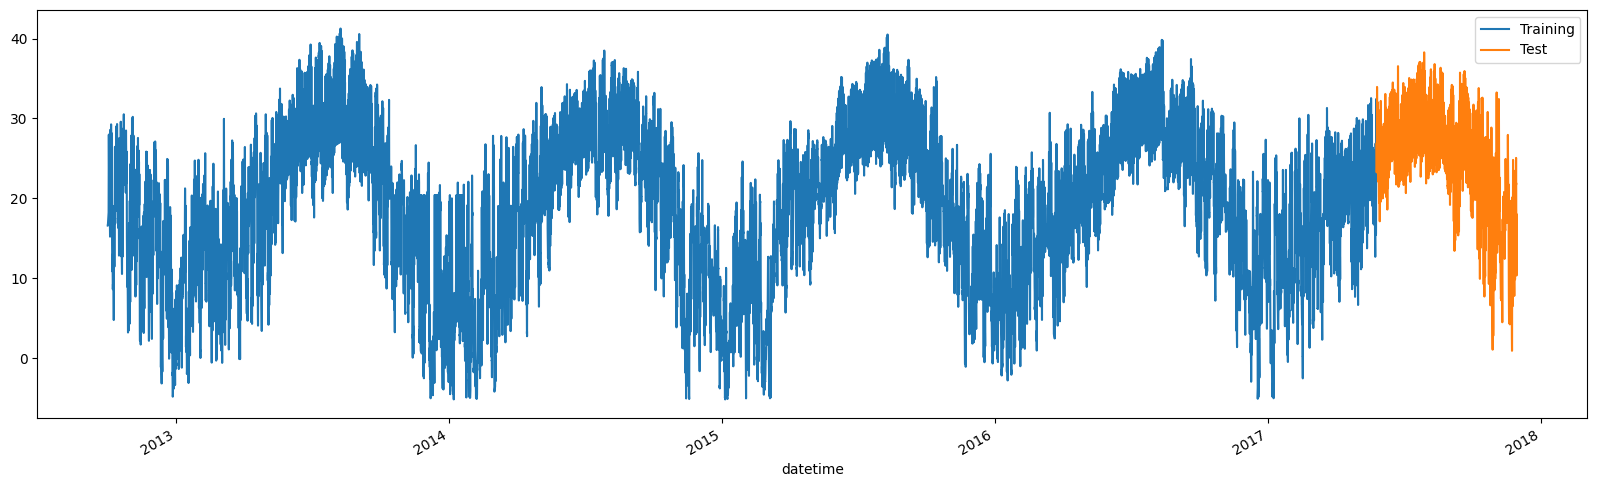

In [24]:
plt.figure(figsize=(20,6))
train_df["temp_C"].plot()
test_df["temp_C"].plot()
plt.legend(['Training','Test'])
plt.show()

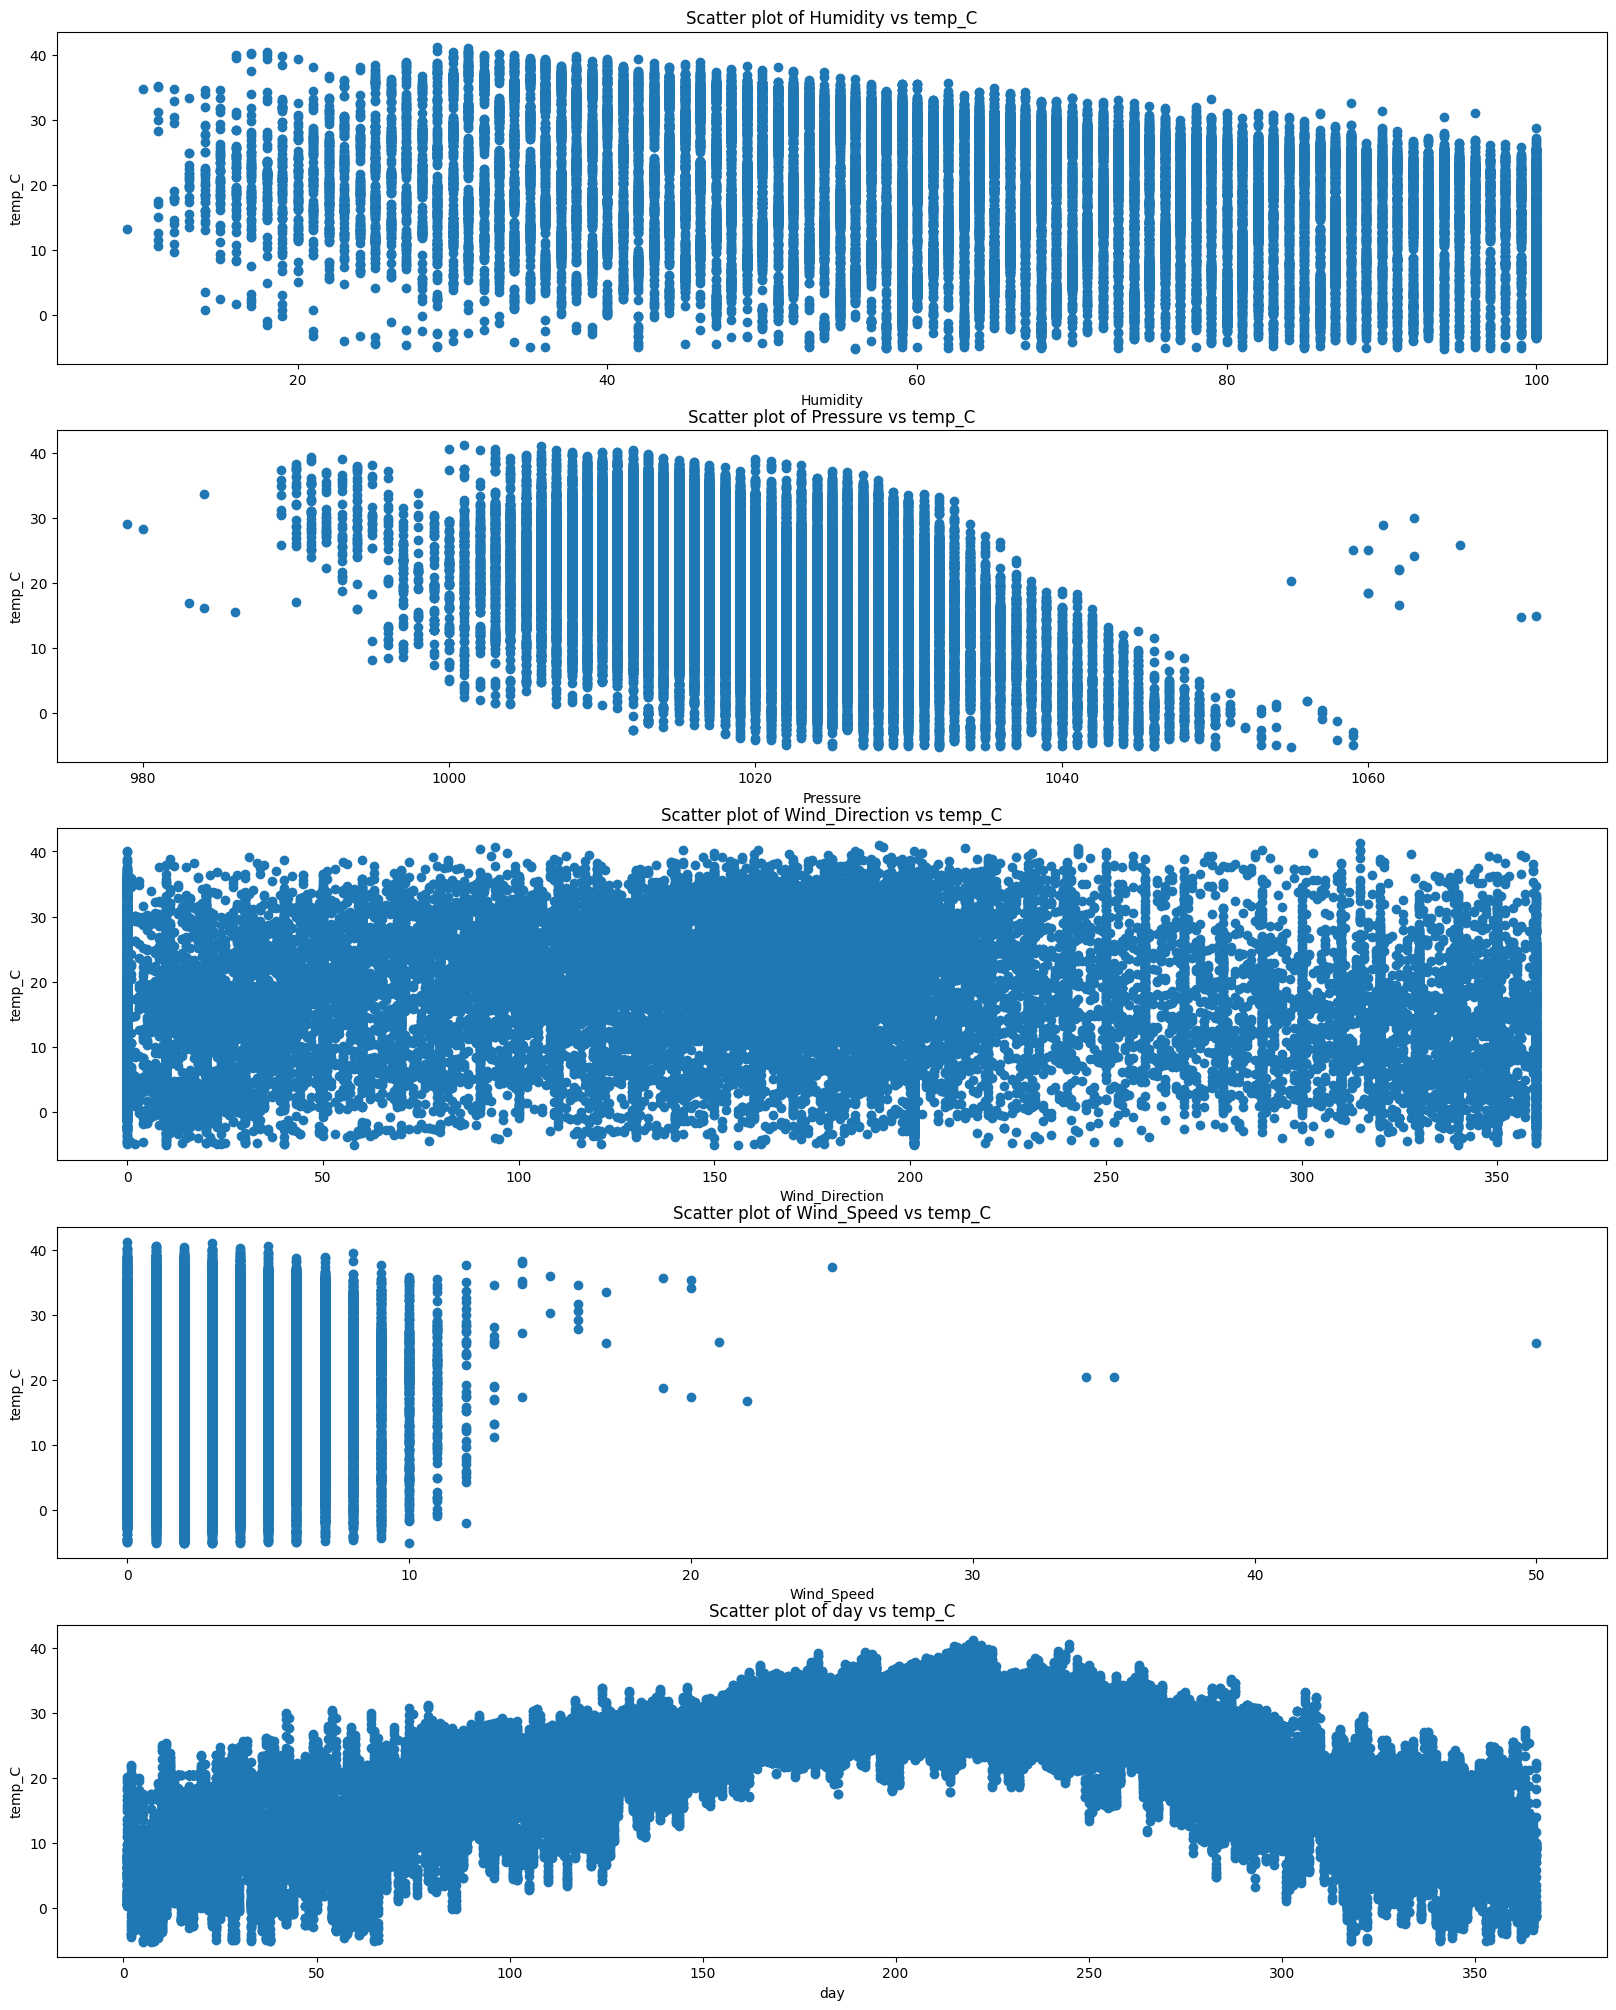

In [25]:
#Plotting the relations between explanatory and response variables
cols = ['Humidity', 'Pressure', 'Wind_Direction', 'Wind_Speed', "day"]

fig, ax = plt.subplots(5,1, figsize=(20,25))
for i, var in enumerate(cols):
    ax[i].scatter(df[var], df["temp_C"])
    ax[i].set_xlabel(var)
    ax[i].set_ylabel("temp_C")
    ax[i].set_title(f'Scatter plot of {var} vs temp_C')
plt.show()

In [26]:
# Standarize numerical variables for Neural Network
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = scaler_X.fit_transform(train_df.drop(columns=["temp_C", "Temperature", "City"]).values.astype('float32'))
Y_train = scaler_Y.fit_transform(train_df["temp_C"].values.astype('float32').reshape(-1,1))
X_test = scaler_X.transform(test_df.drop(columns=["temp_C", "Temperature", "City"]).values.astype('float32'))
Y_test = scaler_Y.transform(test_df["temp_C"].values.astype('float32').reshape(-1,1))

In [27]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [28]:
tf.keras.backend.clear_session()
# The LSTM architecture
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1],1)))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

2024-06-06 07:17:24.637715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 07:17:24.867829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 07:17:24.868080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [29]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 37, 50)            10400     
                                                                 
 batch_normalization (Batch  (None, 37, 50)            200       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 37, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 37, 50)            20200     
                                                                 
 batch_normalization_1 (Bat  (None, 37, 50)            200       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 37, 50)            0

Epoch 1/50


2024-06-06 07:17:37.128069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-06 07:17:38.126433: I external/local_xla/xla/service/service.cc:168] XLA service 0x7029b4129600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 07:17:38.126462: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-06 07:17:38.142227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717651058.228999   10364 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


812/812 [==============================] - 13s 8ms/step - loss: 0.6452 - val_loss: 0.1820
Epoch 2/50
812/812 [==============================] - 6s 7ms/step - loss: 0.3107 - val_loss: 0.1591
Epoch 3/50
812/812 [==============================] - 6s 7ms/step - loss: 0.2556 - val_loss: 0.1485
Epoch 4/50
812/812 [==============================] - 6s 7ms/step - loss: 0.2337 - val_loss: 0.1340
Epoch 5/50
812/812 [==============================] - 5s 7ms/step - loss: 0.2156 - val_loss: 0.2076
Epoch 6/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1912 - val_loss: 0.1422
Epoch 7/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1795 - val_loss: 0.1545
Epoch 8/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1737 - val_loss: 0.1111
Epoch 9/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1690 - val_loss: 0.1140
Epoch 10/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1631 - val_loss: 0.1206
Epoch 11/

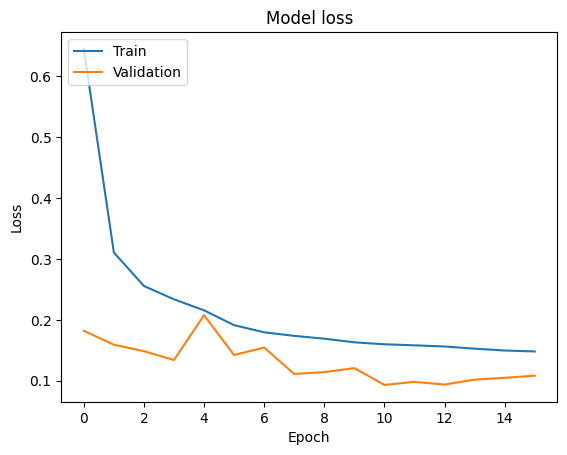

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fitting to the training set
history = regressor.fit(X_train, Y_train, epochs=50, batch_size=50, callbacks=[early_stopping], validation_data=(X_test, Y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

In [31]:
predictions = regressor.predict(X_test)
pred_inv = scaler_Y.inverse_transform(predictions)

predictions_train = regressor.predict(X_train)
pred_train_inv = scaler_Y.inverse_transform(predictions_train)

Y_test_inv = scaler_Y.inverse_transform(Y_test)
Y_train_inv = scaler_Y.inverse_transform(Y_train)

1268/1268 [==============================] - 3s 2ms/step


<Figure size 2000x600 with 0 Axes>

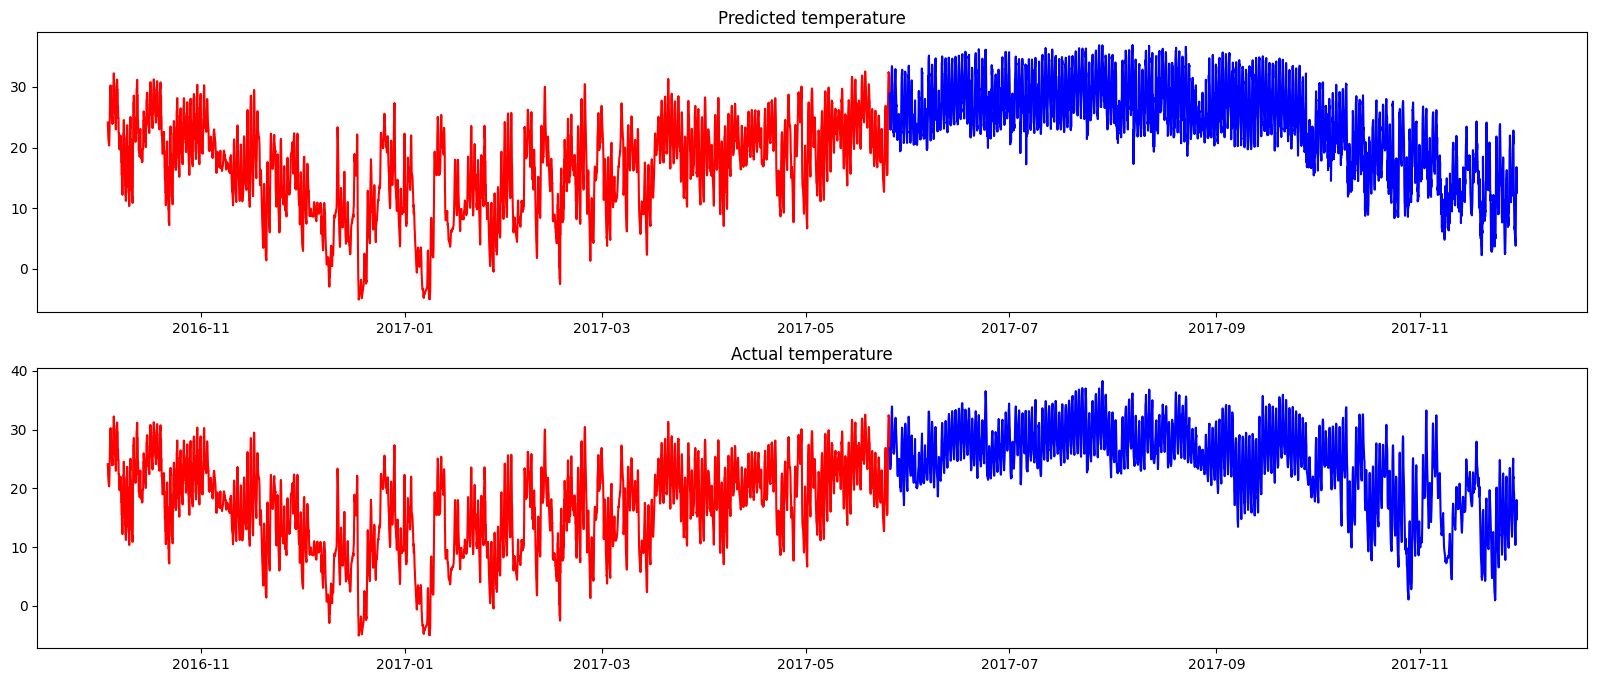

In [32]:
# Predictions
plt.figure(figsize=(20,6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
ax1.plot(train_df.index[35000:], Y_train_inv[35000:], color="red")
ax1.plot(test_df.index, pred_inv[:,0], color="blue")
ax1.set_title('Predicted temperature')
ax2.plot(train_df.index[35000:], Y_train_inv[35000:], color="red")
ax2.plot(test_df.index, Y_test_inv, color="blue")
ax2.set_title('Actual temperature')
plt.show()

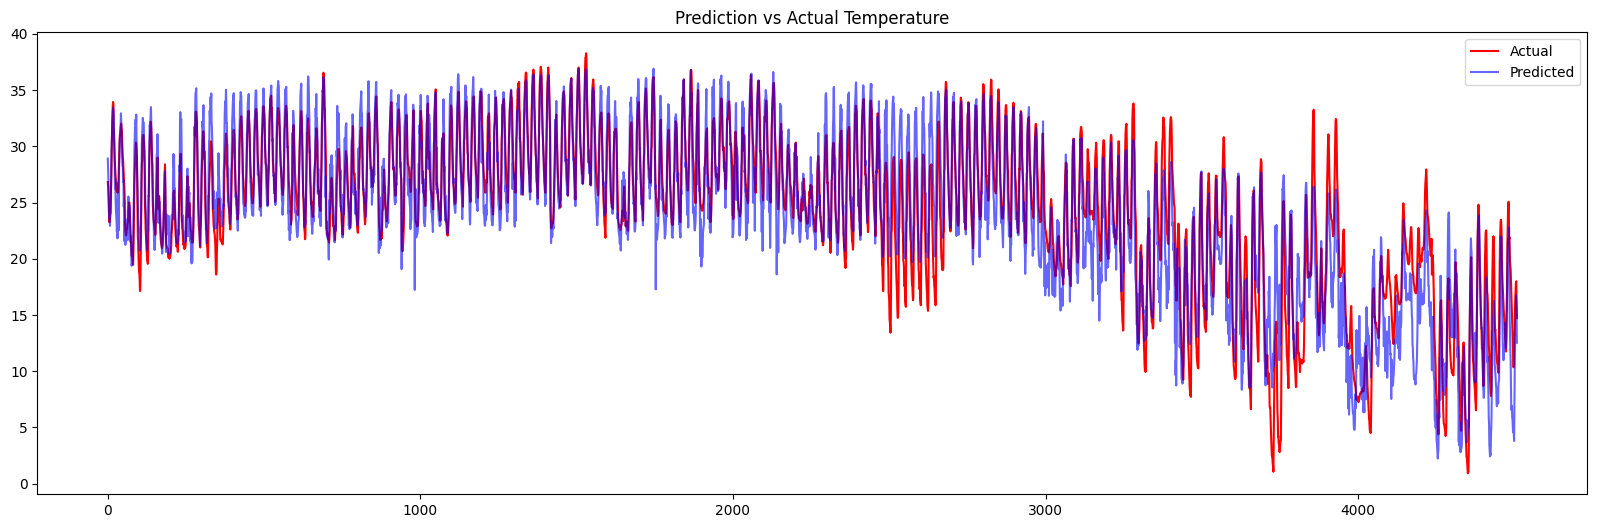

In [44]:
# Actual data
plt.figure(figsize=(20,6))
plt.title("Prediction vs Actual Temperature")
plt.plot(Y_test_inv, color="red", label="Actual")
plt.plot(pred_inv, color="blue", label="Predicted", alpha=0.6)
plt.legend()
plt.show()

In [34]:
# Calculate train MAE
mae_train = mean_absolute_error(Y_train_inv, pred_train_inv)
print(f'Mean Absolute Error (MAE): {mae_train}')

# Calculate train MSE
mse_train = mean_squared_error(Y_train_inv, pred_train_inv)
print(f'Mean Squared Error (MSE): {mse_train}')

# Calculate train RMSE
rmse_train = np.sqrt(mse_train)
print(f'Root Mean Squared Error (RMSE): {rmse_train}')

Mean Absolute Error (MAE): 2.5977516174316406
Mean Squared Error (MSE): 11.760680198669434
Root Mean Squared Error (RMSE): 3.429384708404541


In [35]:
# Calculate test MAE
mae_test = mean_absolute_error(Y_test_inv, pred_inv)
print(f'Mean Absolute Error (MAE): {mae_test}')

# Calculate test MSE
mse_test = mean_squared_error(Y_test_inv, pred_inv)
print(f'Mean Squared Error (MSE): {mse_test}')

# Calculate test RMSE
rmse_test = np.sqrt(mse_test)
print(f'Root Mean Squared Error (RMSE): {rmse_test}')

Mean Absolute Error (MAE): 2.1585423946380615
Mean Squared Error (MSE): 8.240880012512207
Root Mean Squared Error (RMSE): 2.8706932067871094


In [36]:
# We get the errors of a model consiting of just the mean to compare
print('Mean Absolute Error (MAE): ', mean_absolute_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv))))
print('Mean Squared Error (MSE): ', mean_squared_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv))))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_squared_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv)))))

Mean Absolute Error (MAE):  5.2871914
Mean Squared Error (MSE):  46.558987
Root Mean Squared Error (RMSE):  6.823415


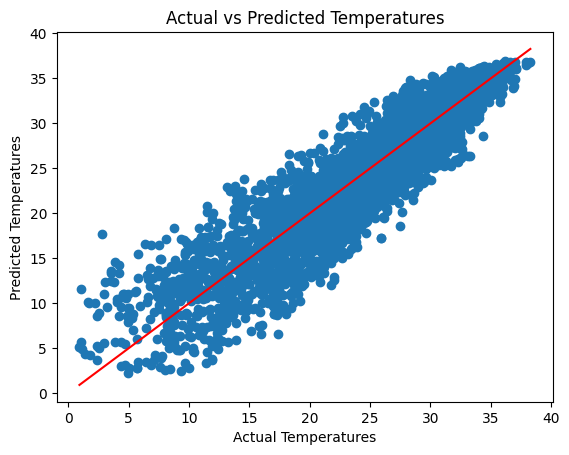

In [37]:
plt.scatter(Y_test_inv, pred_inv)
plt.plot([min(Y_test_inv), max(Y_test_inv)], [min(Y_test_inv), max(Y_test_inv)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Temperatures')
plt.ylabel('Predicted Temperatures')
plt.title('Actual vs Predicted Temperatures')
plt.show()

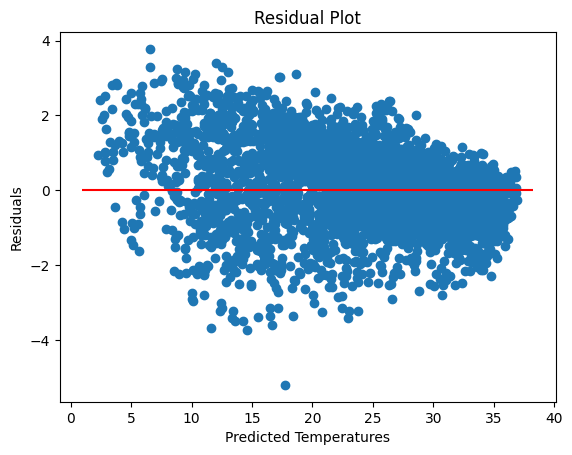

In [38]:
residuals = np.array(Y_test_inv) - np.array(pred_inv)
residuals = residuals/np.std(residuals)
plt.scatter(pred_inv, residuals)
plt.hlines(y=0, xmin=min(Y_test_inv), xmax=max(Y_test_inv), color='red')
plt.xlabel('Predicted Temperatures')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

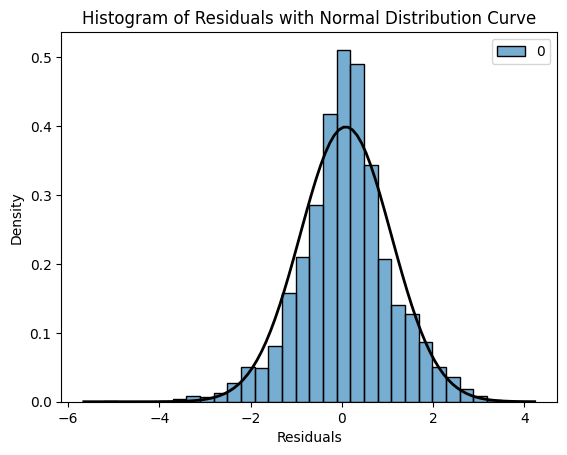

In [39]:
sns.histplot(residuals, kde=False, stat="density", bins=30, color="blue", alpha=0.6)

mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_residuals, std_residuals)

plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals with Normal Distribution Curve')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.show()